In [47]:
import pandas as pd
import time
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

In [48]:
filePath = './Plants_of_me.csv'  # repalce with your own file path

In [49]:
def getMetaData(filePath):
    """transfer csv mate data to dataframe"""
    df = pd.read_csv(filePath)
    return df

df = getMetaData(filePath)
df.head(5)

,Start Time,End Time,Tag,Note,Tree Type,Is Success
0,2019-01-13T10:43:26.000+0800,2019-01-13T11:57:41.000+0800,未设定,NaN,雪松,True
1,2019-01-13T13:00:31.000+0800,2019-01-13T14:11:13.000+0800,未设定,NaN,雪松,True
2,2019-01-13T14:21:06.000+0800,2019-01-13T15:31:12.000+0800,未设定,NaN,雪松,True
3,2019-01-13T15:45:21.000+0800,2019-01-13T16:48:00.000+0800,未设定,NaN,雪松,False
4,2019-01-13T18:00:23.000+0800,2019-01-13T19:00:58.000+0800,未设定,NaN,雪松,False


In [50]:
class Time:
    localTime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())  # YYYY-MM-DD hh:mm:ss
    localDate = localTime.split()[0]  # YYYY-MM-DD
    periodDict = {'week': 7, 'month': 30, 'quarter': 90, 'half a year': 180, 'year': 365}
    
    
    def getDateList(self, startDate: str, endDate: str) -> list:
        """get the date list between start date and end date"""
        dateList = [datetime.strftime(x, '%Y-%m-%d') for x in list(pd.date_range(startDate, endDate))]
        return dateList
    
    
    def getPastDate(self, N: int):
        """Get the date before N days (base on today)"""
        pastDate = date.today() - timedelta(days = N)
        pastDate.strftime('%Y-%m-%d')  # 格式化日期
        return pastDate
        

Input a time of period (Input week with ENTER)
ONLY week / month / quarter / half a year / year ARE SUPPORTED: year


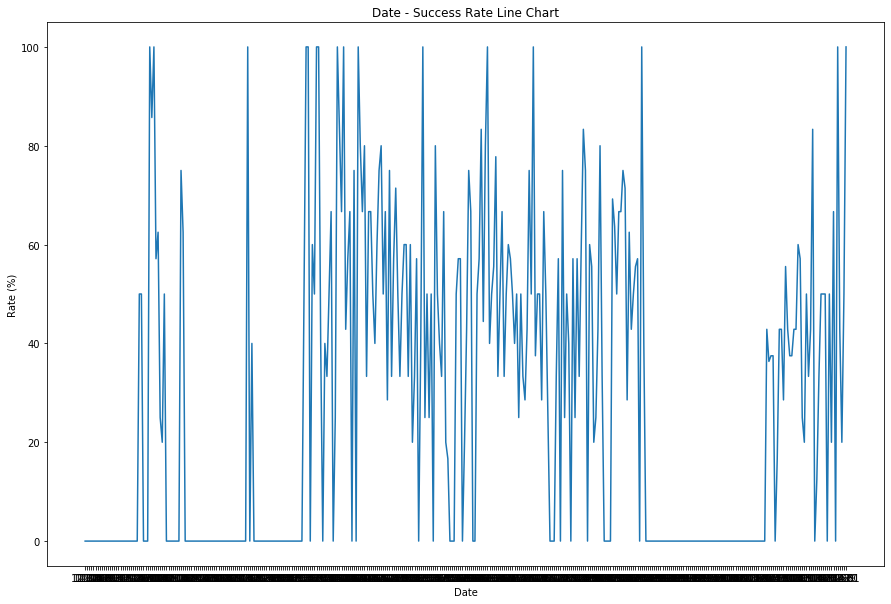

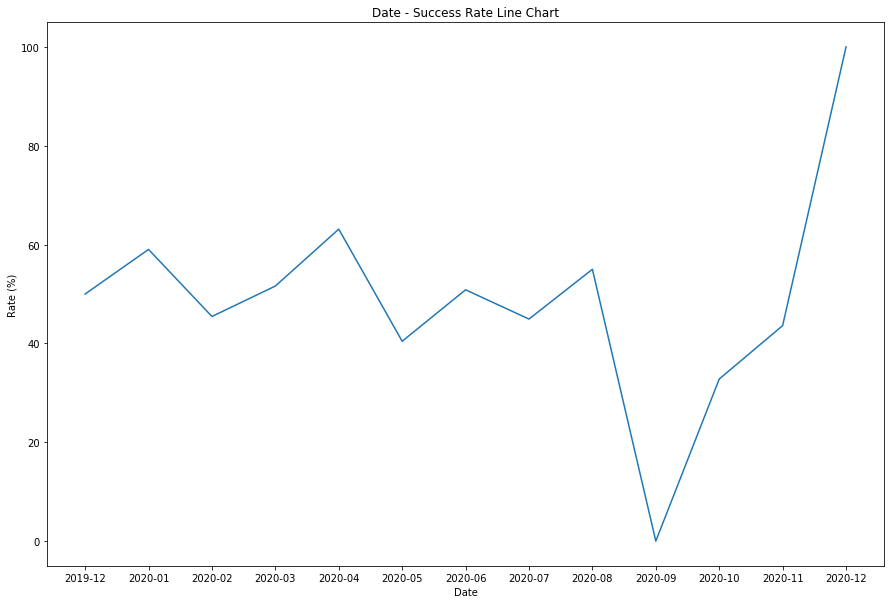

In [55]:
class SuccessAnalysis:
    def __init__(self, df):
        self.df = df
    
    
    def successInDay(self, date=Time.localDate, showResult=False):
        """
        success number / rate in a sepcific day
        :params 
            date: a date with format YYYY-MM-DD, nowtime as default input
            showResult: (bool) whether print result
        :return 
            countTree: (int) the number of trees in the day
            len(dfSuccessTree): (int) the number of successful trees in the day
            successRate: (float) success rate in the day
        """
#         date = input('Input the date in format YYYY-MM-DD (Input Today with ENTER ): ') or Time.localDate
        boolInDate = self.df['Start Time'].str.contains(date)  # transfer to bool
        dfInDate = self.df[boolInDate]  # get all row meet the date condition
        
        try:
            countTree = len(dfInDate)  # eligible tree number in total
            dfSuccessTree = dfInDate.loc[dfInDate['Is Success'] == True]  # successed tree df
            successRate = round((len(dfSuccessTree) / countTree) * 100, 2)  # success rate
        
        except ZeroDivisionError:
            successRate = None
            if showResult:
                print('You do not have a tree in {}'.format(date), end = '\n\n')
        
        else:
            if showResult:
                print('In {}, there are {} trees, {} of which are successful, the success rate is {}%'
                      .format(date, countTree, len(dfSuccessTree), successRate), end = '\n\n')
            pass
        return countTree, len(dfSuccessTree), successRate if successRate else 0.0  # assign 0 for the day does not have a tree
    
    
    def successInTimePeriod(self):
        """success number / rate in a time of period"""
        timePeriod = input(
            'Input a time of period (Input week with ENTER)\n'
            'ONLY week / month / quarter / half a year / year ARE SUPPORTED: ').strip() or 'week'  # week as default
        if timePeriod not in ['week', 'month', 'quarter', 'half a year', 'year']: 
            raise NameError ('The Input Name Is Error, Please Input Again.')
        
        periodInDays = Time.periodDict[timePeriod]
        t = Time()
        pastDate = t.getPastDate(periodInDays)
        dateList = t.getDateList(pastDate, Time.localDate)
        # get cusscessful rate list correspond to dateList
        successRateList = [self.successInDay(d)[-1] for d in dateList]
        return dateList, successRateList    
    
    
    def plotSuccess(self, dates: list, sucRates: list):
        """
        Plot dates - success rate Line Chart
        :params dates: a list of dates with format YYYY-MM-DD
        :params sucRates: a list of success rate correspond to dates
        """
        if len(dates[0].split('-')) > 2:
            dates = ['.'.join(day.split('-')[1:]) for day in dates]  # re-format day to month 

        X, Y = dates, sucRates
#         width, height = len(dates), int(len(dates) * 2 / 3)
#         figsize = None if width is None else (width, height)
        plt.figure(figsize=(15,10))  # TODO: auto size
        plt.plot(X, Y)
        plt.title('Date - Success Rate Line Chart')
        plt.xlabel('Date')
        plt.ylabel('Rate (%)')
        plt.autoscale(enable=True, axis='both', tight=False)
        
    
    def aveSucRate(self, days: list):
        """
        Get average success rate according to month
        :params days: a list of days with format YYYY-MM-DD
        :return
            list(treeDict): a list of month
            list(treeDict.values()): a list of success rate correspond to the month 
        formula: 
            number of success in month / number of trees in month
        """
        treeDict = {}  # use a dict to count trees, format with date: [succ, total]
        for day in days:
            countTree, successTree, _ = self.successInDay(day)
            month = '-'.join(day.split('-')[:-1])
            if month not in treeDict:
                treeDict[month] = [successTree, countTree]
            else:
                treeDict[month][0] += successTree
                treeDict[month][1] += countTree
        # calculate success rate
        for key, value in treeDict.items():
            successRate = round((value[0]/value[1])*100, 2) if value[1] != 0 else 0.0
            treeDict[key] = successRate
        return list(treeDict), list(treeDict.values())  # month, success rate
        
    
        
s = SuccessAnalysis(df)
# _ = s.successInDay(date='2020-05-01',showResult=True)  # analyse a specific date success situation

days, succ = s.successInTimePeriod()
s.plotSuccess(days, succ)  # plot success rate in days

mon, succMon = s.aveSucRate(days)
s.plotSuccess(mon, succMon)  # plot success rate in months